In [1]:
import pandas as pd

In [32]:
files = [
    '../data/processed/squats/How-To-Barbell-Squat-with-Krissy-Cela-YouTube.csv',
    '../data/processed/squats/How-to-Squat-Properly-Form-Fixes-Tips-Myths-YouTube.csv',
    '../data/processed/squats/TARGET-YOUR-GLUTES-NOT-YOUR-QUADS-Glute-Series-Ep9-YouTube.csv',
]
dfs = [pd.read_csv(file) for file in files]
df = pd.concat(dfs).dropna(subset=['label']).reset_index()
df.shape

(4676, 339)

In [4]:
from tupuedes.analysis import FullBodyPoseEmbedder
from tupuedes.poses import SquatClassifier

In [68]:
embedder = FullBodyPoseEmbedder()
classifier = SquatClassifier()

In [46]:
import numpy as np

def row2array(row):
    data = []
    point = []
    for column in row.index:
        if column.startswith('relative_') and column[-2:] in ['_x', '_y', '_z']:
            point.append(row[column])
            if len(point) == 3:
                data.append(point)
                point = []

    return np.array(data)

df.sample(n=1).apply(row2array, axis=1)

1455    [[-0.1331539303064346, -0.6234725117683411, -0...
dtype: object

In [47]:
df['landmarks_array'] = df.apply(row2array, axis=1)

In [48]:
df['embeddings'] = df.landmarks_array.apply(embedder)

<AxesSubplot:>

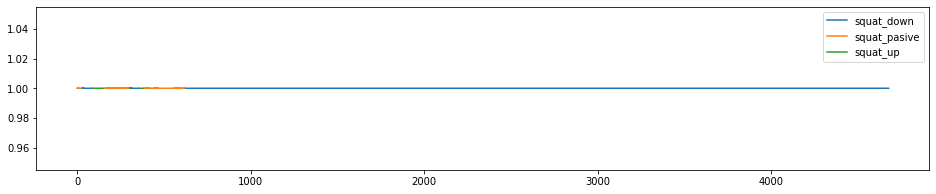

In [80]:
classifier = SquatClassifier()
def predictor_generator(row):
    global classifier
    if row.label is None:
        classifier = SquatClassifier()
        return None

    return classifier.infer(row.embeddings)



df['predictions'] = df.apply(predictor_generator, axis=1)
dummies = pd.get_dummies(df.predictions, dummy_na=True)
dummies[dummies.columns].replace({0: None}).plot(figsize=(16, 3))

<AxesSubplot:>

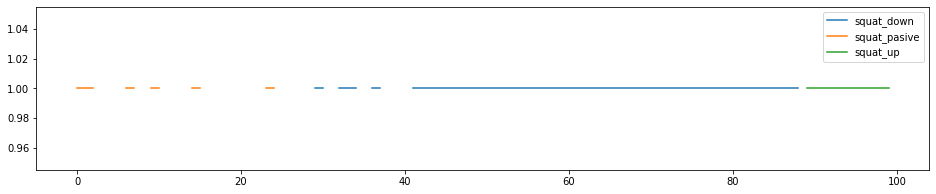

In [76]:

dummies = pd.get_dummies(df.predictions, dummy_na=True)
dummies[dummies.columns].replace({0: None})[:100].plot(figsize=(16, 3))

In [74]:
df.loc[20].predictions

'squat_down'

In [77]:
df.predictions.value_counts()

squat_down      4279
squat_pasive     306
squat_up          91
Name: predictions, dtype: int64

<AxesSubplot:>

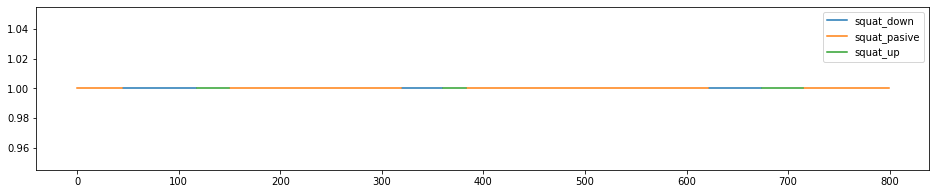

In [70]:
dummies = pd.get_dummies(df.label, dummy_na=True)
dummies[dummies.columns].replace({0: None})[:800].plot(figsize=(16, 3))

<AxesSubplot:>

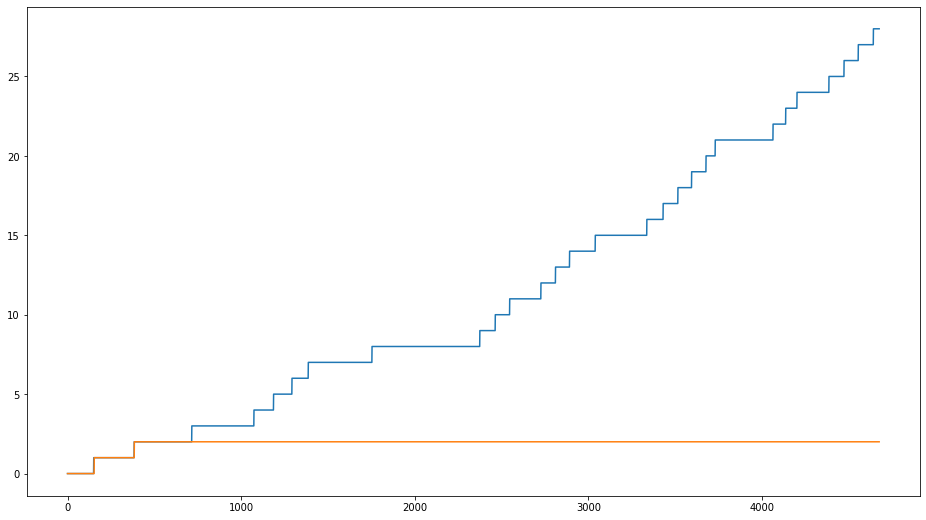

In [66]:
class LabelToCounter:
    def __init__(self):
        self.counter = 0
        self.squat_downs = 0
        self.squat_ups = 0

    def count(self, label):
        if label == 'squat_pasive' and self.squat_downs >= 10 and self.squat_ups >= 10:
            self.counter += 1
            self.squat_downs = 0
            self.squat_ups = 0
        elif label == 'squat_down':
            self.squat_downs += 1
        elif label == 'squat_up':
            self.squat_ups += 1

        return self.counter

label_to_counter = LabelToCounter()
prediction_to_counter = LabelToCounter()

df['counter'] = df.label.apply(label_to_counter.count)
df['prediction_counter'] = df.predictions.apply(prediction_to_counter.count)
df.counter.plot()
df.prediction_counter.plot(figsize=(16,9))

In [52]:
label_to_counter

In [54]:
LabelToCounter().squat_downs

AttributeError: 'LabelToCounter' object has no attribute 'squat_downs'